# This script grabs all relevant data in a 25km x 25 km region in the prestorm environment needed to create soundings text files for CM1.

## Import Packages

In [1]:
#Import Necessary Packages
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 
import glob 
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
import random

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


## Import Dataset

In [2]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

#Step 1: Initialization and Input Parameters

#Data at t = 0hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[0])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values + 12.5).argmin()-2
upper_bound_x = np.abs(x_data.values - 12.5).argmin()
lower_bound_y = np.abs(y_data.values + 45).argmin()
upper_bound_y = np.abs(y_data.values + 20).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

## Visualize the Prestorm Environment

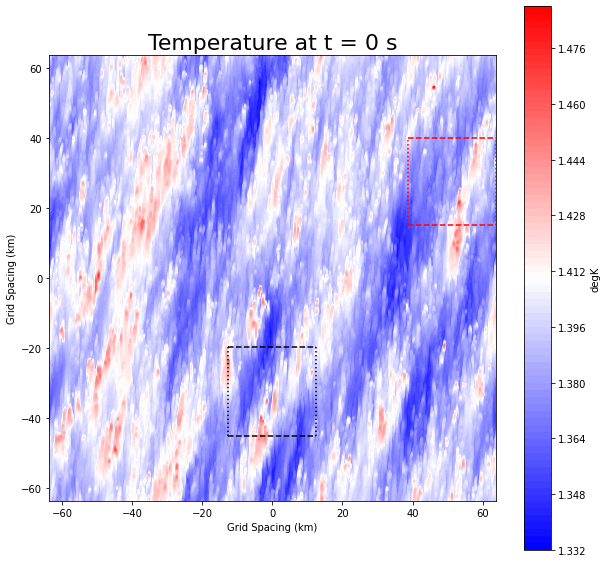

In [7]:
#Create Image For Box Visualization

#Storm 16
dbz_storm16 = []
thpert_storm16 = []

for x in range(len(storm16_files)):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['dbz']
    m = xr.open_dataset(storm16_data_path + storm16_files[x])['thpert']
    dbz_storm16.append(t)
    thpert_storm16.append(m)
    
#Create A Rough Image
#Fix Aspect Ratio
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

#refl = plt.contourf(x_data,y_data,dbz_storm16[1][0].isel(nk = 20), levels=100, cmap ='gist_ncar')
pert = plt.contourf(x_data,y_data, thpert_storm16[0][0][0], levels = 100, cmap ='bwr')
#ncar color bar = gist_ncar
#Set Box Bounds
lower_bound_x, upper_bound_x = x_data[lower_bound_x],x_data[upper_bound_x]
lower_bound_y, upper_bound_y = y_data[lower_bound_y], y_data[upper_bound_y]

#Plot Box of Domain of Interest
#Plot horizontal lines for the top and bottom of the box
ax.plot([lower_bound_x, upper_bound_x], [lower_bound_y, lower_bound_y], color='k', linestyle='--')
ax.plot([lower_bound_x, upper_bound_x], [upper_bound_y, upper_bound_y], color='k', linestyle='--')

# Plot vertical lines for the left and right of the box
ax.plot([lower_bound_x, lower_bound_x], [lower_bound_y, upper_bound_y], color='k', linestyle=':')
ax.plot([upper_bound_x, upper_bound_x], [lower_bound_y, upper_bound_y], color='k', linestyle=':')

# Plot Original Box
ax.plot([x_data.max().values-25, x_data.max().values], [15, 15], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values], [40, 40], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values-25], [15, 40], color='r', linestyle=':')
ax.plot([x_data.max().values, x_data.max().values], [15, 40], color='r', linestyle=':')

plt.title(f"Temperature at t = 0 s", fontsize=22)
plt.colorbar(pert, label = 'degK')
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
ax.set_aspect('equal')

## Read in the Trajectory Data and Necessary Model Data

In [5]:
#Compute Temperature from pressure and potential temperature using adiabatic relationship
def comp_T_from_Th(pressure, pot_temperature):
    P_0 = 100000
    R_d = 287 #J/(kg*K)
    c_p = 1004 #J/(kg*K)
    K = R_d/c_p
    T = pot_temperature*(P_0/pressure/100)**(-K)
    
    return T;

#Compute Dewpoint Temperature from pressure, temperature, and specific humidity
def comp_dewpoint(pressure, temperature, specific_humidity):
    
    q = specific_humidity
    eps = 0.622
    
    #mixing ratio
    w = q/(1-q)
    
    #vapor pressure (in Pa converted to mb)
    e = 0.01*(pressure*100*w)/(eps+w)
    
    #Dewpoint from Bolton 1980
    T = (243.5*np.log(e/6.112))/(17.67-np.log(e/6.112))+273.15
    
    return T;   

In [6]:
#Points From Trajectories
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/Data/'
traj_points = np.load(path+'interpolation_2_rawtrajectories.npz')['interp_points']

#We need to find the index nearest for each trajectory starting point to pinpoint the instaneous profile

#Grid Values
x = x_data.values
y = y_data.values
z = z_data.values


#Format of nearest index: sz,sy,sx
#Create Index Storage
inst_ind = np.zeros((traj_points[0].shape), dtype = int)

#Create A Loop That Finds Nearest Index For Every Starting Point
for i in tqdm(np.arange(0, (traj_points[0]).shape[0],1)):
    xp = traj_points[0][i,2]
    yp = traj_points[0][i,1]
    zp = traj_points[0][i,0]
    
    sx = np.searchsorted(x, xp)
    sy = np.searchsorted(y, yp)
    sz = np.searchsorted(z, zp) - 1
    
    inst_ind[i] = sz,sy,sx
    

#Max and Min Of Each Index Range
z_min = inst_ind[:,0].min()
z_max = inst_ind[:,0].max()
y_min = inst_ind[:,1].min()
y_max = inst_ind[:,1].max()
x_min = inst_ind[:,2].min()
x_max = inst_ind[:,2].max()

#Shift Inst_Ind Array 
inst_ind[:,0] = inst_ind[:,0] - z_min
inst_ind[:,1] = inst_ind[:,1] - y_min
inst_ind[:,2] = inst_ind[:,2] - x_min

#Instantaneous Data From Model Output (t = 30s : start of weather sonde lifting)
#Trim the Data We Are Bringing in Based on index range to cut down computation time
inst_storm_data = xr.open_dataset(storm16_data_path + storm16_files[0])[['prs','th','qv','uinterp','vinterp','winterp','zvort']].isel(time=0, nj=slice(y_min, y_max+1), ni=slice(x_min, x_max+1))

#Decomposing Preemptively into arrays to save additional time
# Create Variables Needed
P_data = inst_storm_data['prs'].values/100 # units of hPa = mb
Th_data = inst_storm_data['th'].values # units of K
qv_data = inst_storm_data['qv'].values*1000 # units of g/kg
u_data = inst_storm_data['uinterp'].values # units of m/s
v_data = inst_storm_data['vinterp'].values # units of m/s
w_data  = inst_storm_data['winterp'].values # units of m/s
zvort_data = inst_storm_data['zvort'].values # units of 1/s
z = z_data.values*1000 # units of m
z = np.round(z,4)   




100%|██████████| 112225/112225 [00:01<00:00, 91141.59it/s]


In [7]:
# Reshape the Data

#Create Storage Arrays
P = np.zeros((121,112225))
Th = np.zeros((121,112225))
qv = np.zeros((121,112225))
u = np.zeros((121,112225))
v = np.zeros((121,112225))
w = np.zeros((121,112225))
zvort = np.zeros((121,112225))

for i in tqdm(np.arange(0,traj_points.shape[1],1)):
    #Decompose Indices Array
    sy = inst_ind[i,1]
    sx = inst_ind[i,2]
    
    #Grab Appropriate Vertical Column
    P[:,i] = P_data[:,sy,sx]
    Th[:,i] = Th_data[:,sy,sx]
    qv[:,i] = qv_data[:,sy,sx]
    u[:,i] = u_data[:,sy,sx]
    v[:,i] = v_data[:,sy,sx]
    w[:,i] = w_data[:,sy,sx]
    zvort[:,i] = zvort_data[:,sy,sx]

#Now Let's Work on Doing Calculations To Create Soundings (Only Run Once)

#Create New Variables

T = np.zeros(P.shape)
Td = np.zeros(P.shape)

#I personally don't like metpy for the calculations. I'm going to create two functions that do metpy things better.
for i in tqdm(np.arange(0,P.shape[1],1)):
    T[:,i] = comp_T_from_Th(P[:,i], Th[:,i])
    Td[:,i] = comp_dewpoint(P[:,i], T[:,i], qv[:,i]/1000)
    

100%|██████████| 112225/112225 [00:03<00:00, 35633.47it/s]


## Building the Soundings

In [13]:
# Random Sounding Selector

# Will generate a random number between 0 and 112225 to select a pseudo-sounding at random
# Goal: 40 Unique Soundings
# If a random number has already been generated, must include condition that does not add it to the 

# Empty Storage Array
sounding_id = []

while len(sounding_id) < 30:
    rand_int = random.randint(0,112225)
    if np.all(sounding_id != rand_int):
        sounding_id.append(rand_int)
        
# Convert to Numpy Array
sounding_id = np.asarray(sounding_id)

In [14]:
#Function that Builds input_sounding.txt file

def create_sounding_txt(ID):
    input_sounding = open(f"input_sounding_{ID}.txt", 'w')
    
    # Create Values for 1st Level using second order extrapolation
    # a(z=0) = c1*a(z=7.5) + c2*a(z=22.5) + c3*a(z=37.5)
    c1 = 1.875
    c2 = -1.25
    c3 = 0.375
    P_0 = c1*P[0,ID] + c2*P[1,ID] + c3*P[2,ID]
    Th_0 = c1*Th[0,ID] + c2*Th[1,ID] + c3*Th[2,ID]
    qv_0 = c1*qv[0,ID] + c2*qv[1,ID] + c3*qv[2,ID]
    
    # Write 1st Initial Condition Level
    input_sounding.write(f'{P_0}    {Th_0}    {qv_0}\n')
    
    for x in range(121):
        # Add each vertical level of data
        input_sounding.write(f'{z[x]}    {Th[x,ID]}    {qv[x,ID]}    {u[x,ID]}    {v[x,ID]}\n')
    # Need to Interpolate a Final Vertical Level to Make CM1 Happy (z_top = 18300)
    interpolator_Th = interp1d(z[-2:], Th[-2:,ID], kind='linear', fill_value='extrapolate')
    interpolator_qv = interp1d(z[-2:], qv[-2:,ID], kind='linear', fill_value='extrapolate')
    interpolator_u = interp1d(z[-2:], u[-2:,ID], kind='linear', fill_value='extrapolate')
    interpolator_v = interp1d(z[-2:], v[-2:,ID], kind='linear', fill_value='extrapolate')
    
    # Add the Final Level
    z_top = 18500
    input_sounding.write(f'{z_top}    {interpolator_Th(z_top)}    {interpolator_qv(z_top)}    {interpolator_u(z_top)}    {interpolator_v(z_top)}\n')
    input_sounding.close()

In [15]:
# Build Soundings and Save
for x in sounding_id:
    create_sounding_txt(x)

## Visualize a sounding

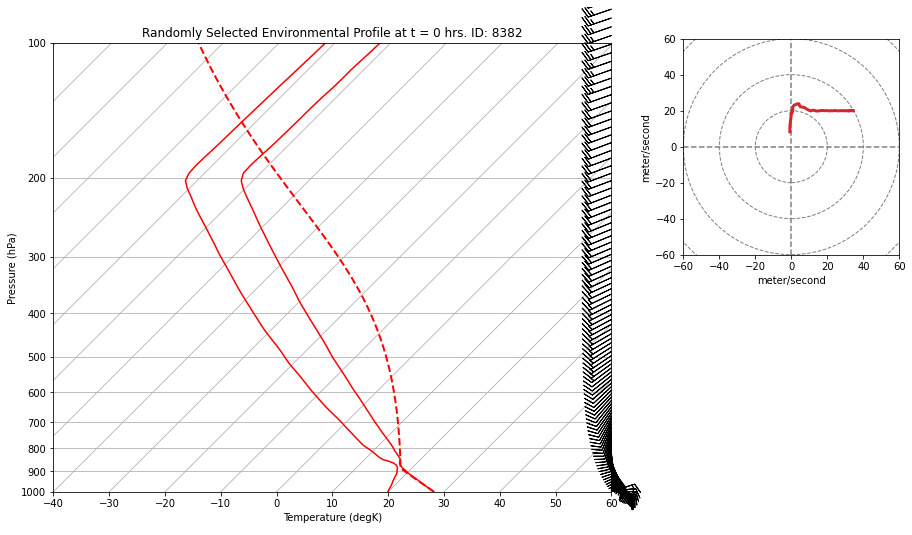

In [88]:
#Plotting the Sounding

fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)
i = sounding_id[39]
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(P[:,i]*units.hPa, T[:,i]*units.degK, 'r')
skew.plot(P[:,i]*units.hPa, Td[:,i]*units.degK, 'r')
skew.plot_barbs(P[:,i]*units.hPa, u[:,i]*units('m/s'), v[:,i]*units('m/s'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
skew.ax.set_title(f'Randomly Selected Environmental Profile at t = 0 hrs. ID: {i}')
skew.ax.set_xlabel(f'Temperature (degK)')
skew.ax.set_ylabel(f'Pressure (hPa)')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(P[:,i]*units.hPa, T[:,i][0]*units.degK, Td[:,i][0]*units.degK).to('degC')
skew.plot(P[:,i]*units.hPa, prof, 'r--', linewidth=2)

# Add the relevant special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
#skew.plot_mixing_lines()

#Relative Storm Motion 
offset_u = 12.2*units.meter_per_second
offset_v = 12.5*units.meter_per_second

#Add Hodograph
ax = plt.axes((1, 0.52, 0.3, 0.3))
h = metpy.plots.Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot(u[:,i]*units('m/s')+offset_u, v[:,i]*units('m/s')+offset_v, color='tab:red')

# Show the plot
plt.show()
